# Clasificación de Imágenes de Cáncer de Mama con Redes Neuronales Convolucionales

# Objetivos del Proyecto
Desarrollar una red neuronal convolucional (CNN) para clasificar imágenes


1.   Desarrollar una red neuronal convolucional (CNN) para clasificar imágenes histológicas de tejido mamario en categorías de cáncer benigno o maligno
2. Entrenar el modelo en un conjunto de datos de imágenes médicas de alta calidad.
3. Evaluar el rendimiento del modelo en términos de precisión, sensibilidad, especificidad y matriz de confusión.
4. Realizar predicciones sobre un conjunto de imágenes nuevas y analizar los resultados.

# Dataset
Para este proyecto, se utilizó el dataset Breast Cancer Histopathology Images de TensorFlow, El cual se encuentra en la siguiente URL:https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images. Este dataset contiene imágenes de biopsias de mama con etiquetas que indican si el tejido es maligno o benigno.

# Importacion de Librerias

In [ ]:
# Importar librerías
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Import ImageDataGenerator explicitly
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras.saving

# Cargar y procesar el dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

100%|██████████| 3.10G/3.10G [00:40<00:00, 82.5MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


Contenido del directorio del dataset: ['10278', '10259', '15512', '9081', '10305', '9319', '10291', '12883', '13458', '13018', '14192', '12930', '12900', '13459', '9258', '15513', '13691', '9076', '12879', '12810', '10286', '9023', '10295', '12891', '9123', '12892', '14321', '12935', '9347', '12626', '9290', '9261', '10304', '9256', '12954', '9181', '14154', '9043', '9344', '8957', '16550', '14210', '10306', '10254', '10290', '12877', '8914', '14212', '10292', '14153', '12897', '15840', '13403', '9036', '10274', '12949', '12886', '16552', '15634', '10293', '8918', '12748', '13460', '10268', '8913', '9177', '9176', '16085', '12811', '12826', '14305', '13400', '16532', '9266', '12882', '16014', '9228', '12867', '10260', '16551', '12908', '12876', '8980', '15516', '13666', '12872', '12820', '9124', '12752', '14209', '12907', '12869', '15510', '8863', '9226', '12823', '9345', '13687', '12824', '9041', '9075', '13106', '12819', '12947', '12948', '8955', '9323', '9078', '9037', '16554', '129

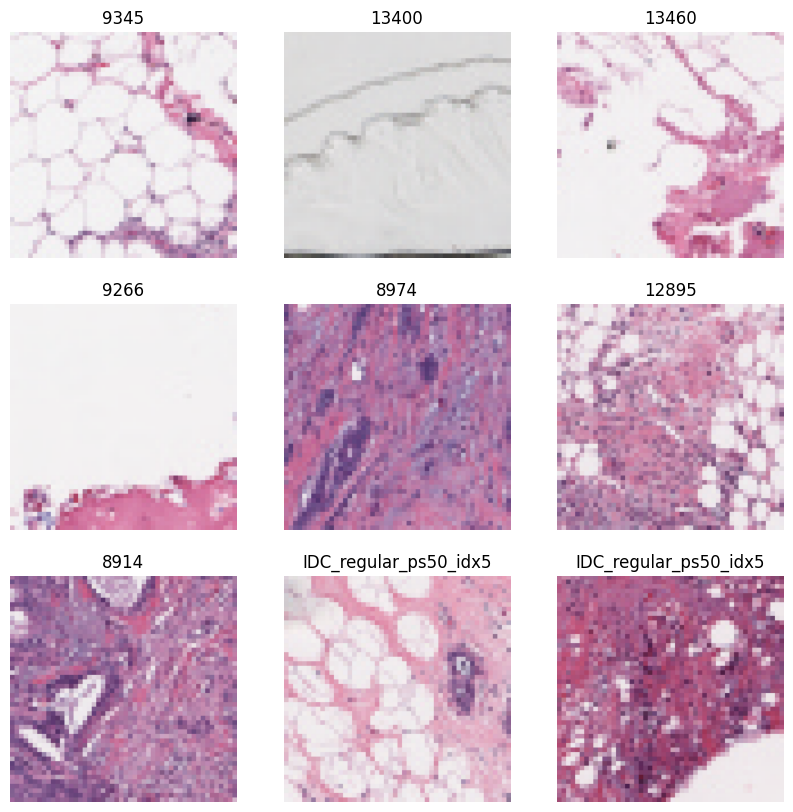

In [ ]:
# Ruta del dataset
dataset_dir = path  # Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1

# Verifica si el dataset contiene subcarpetas 'benign' y 'malignant'
print("Contenido del directorio del dataset:", os.listdir(dataset_dir))

# Carga y procesamiento de imágenes
batch_size = 32
img_height = 150
img_width = 150

# Configuración del generador de datos de entrenamiento y validación
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # Utilizamos el 20% de los datos para validación
)

# Generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Generador de validación
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Mostrar algunas imágenes del dataset
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    break  # Mostrar solo una tanda de imágenes
plt.show()


# Configurar el rendimiento del dataset
Este paso es indispensable, debido a que permite optimizar la carga y procesamientp de datos durante el entrenamiento del modelo

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE  # TensorFlow determina automáticamente el valor óptimo

# Convertir el generador en tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

# Optimización del rendimiento
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [1]:
import tensorflow as tf

# Parámetros de tamaño de imagen reducidos
img_height, img_width = 128, 128

# Reducir la cantidad de datos en el generador de entrenamiento y validación
# Ajustando el batch_size y limitando el número de muestras tomadas

def limit_data(generator, limit=0.1):
    """Función para limitar el generador a una fracción de los datos originales."""
    for i, (images, labels) in enumerate(generator):
        if i >= int(len(generator) * limit):  # Solo tomar un 10% de los datos
            break
        yield images, labels

# Convertir el generador limitado en tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: limit_data(train_generator, limit=0.1),  # Limitar a 10% del conjunto original
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: limit_data(validation_generator, limit=0.1),  # Limitar a 10% del conjunto original
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

# Optimización del rendimiento
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Crear la red convolucional
Para este modelo se construyó una CNN simple con capas de convolución y de pooling, terminando con una capa densa para la clasificación.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Definir el modelo CNN optimizado
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # Reducción de filtros
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),  # Reducción de filtros
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Regularización L2
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Mostrar el resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,235,361 (12.34 MB)

 Trainable params: 3,235,361 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Definir el modelo CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Mostrar el resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

# Compilar y entrenar el modelo
Para este modelo se utiliza el optimizador Adam el cual es eficiente para entrenar redes neuronales profundas. Este optimizador adapta las tasas de aprendizaje para cada parámetro de manera individual, lo que le permite converger más rápido y de manera más estable. Asi mismo, se empleó la función de pérdida y métricas de evaluación para medir el rendimiento del modelo durante el entrenamiento.

In [7]:
import pandas as pd
import tensorflow as tf

# Leer el archivo CSV
data = pd.read_csv('/content/sample_data/mnist_train_small.csv')

# Asumiendo que el CSV tiene columnas 'file_path' y 'label'
file_paths = data['file_path'].values  # Ruta de las imágenes
labels = data['label'].values  # Etiquetas de las imágenes

# Crear una función para cargar y preprocesar las imágenes
def load_and_preprocess_image(file_path, label):
    # Leer la imagen
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Ajustar si las imágenes no son JPEG
    img = tf.image.resize(img, [128, 128])  # Ajusta el tamaño según sea necesario
    img = img / 255.0  # Normalizar entre 0 y 1
    return img, label

# Crear el tf.data.Dataset desde las rutas de archivo y etiquetas
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Dividir el conjunto de datos para entrenamiento y validación
train_size = int(0.8 * len(file_paths))
train_ds = dataset.take(train_size)
import pandas as pd
import tensorflow as tf

# Leer el archivo CSV
data = pd.read_csv('/content/sample_data/mnist_train_small.csv')

# Asumiendo que el CSV tiene columnas 'file_path' y 'label'
file_paths = data['file_path'].values  # Ruta de las imágenes
labels = data['label'].values  # Etiquetas de las imágenes

# Crear una función para cargar y preprocesar las imágenes
def load_and_preprocess_image(file_path, label):
    # Leer la imagen
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Ajustar si las imágenes no son JPEG
    img = tf.image.resize(img, [128, 128])  # Ajusta el tamaño según sea necesario
    img = img / 255.0  # Normalizar entre 0 y 1
    return img, label

# Crear el tf.data.Dataset desde las rutas de archivo y etiquetas
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Dividir el conjunto de datos para entrenamiento y validación
train_size = int(0.8 * len(file_paths))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

KeyError: 'file_path'

In [9]:
import pandas as pd
import tensorflow as tf

# Leer el archivo CSV
data = pd.read_csv('/content/sample_data/mnist_train_small.csv')

# Asumiendo que la primera columna es la etiqueta y el resto son los píxeles
# Si tu CSV tiene un nombre de columna diferente para la etiqueta, ajústalo aquí
labels = data['6'].values  # Ajusta 'label' si es necesario
# Eliminar la columna de etiquetas del DataFrame para obtener solo los píxeles
pixels = data.drop('6', axis=1).values  # Ajusta 'label' si es necesario


# Crear una función para preprocesar las imágenes
def preprocess_image(pixels, label):
    # Convertir los píxeles a una imagen
    img = tf.reshape(pixels, [28, 28, 1])  # MNIST son imágenes de 28x28 en escala de grises

    # Normalizar los píxeles entre 0 y 1
    img = tf.cast(img, tf.float32) / 255.0

    # Si tu modelo requiere imágenes RGB, puedes convertirlas:
    # img = tf.image.grayscale_to_rgb(img)

    # Ajustar el tamaño de la imagen si es necesario
    img = tf.image.resize(img, [128, 128])

    return img, label

# Crear el tf.data.Dataset desde los píxeles y etiquetas
dataset = tf.data.Dataset.from_tensor_slices((pixels, labels))
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Dividir el conjunto de datos para entrenamiento y validación
train_size = int(0.8 * len(pixels))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

In [10]:
# Convertir los generadores limitados en tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: limit_data(train_generator, limit=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: limit_data(validation_generator, limit=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)


In [19]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the CSV data
data = pd.read_csv('/content/sample_data/mnist_train_small.csv')

# Assuming the first column is the label and the rest are pixels
labels = data['6'].values
pixels = data.drop('6', axis=1).values

# Preprocess the images (same as in your previous example)
def preprocess_image(pixels, label):
    img = tf.reshape(pixels, [28, 28, 1])
    img = tf.cast(img, tf.float32) / 255.0
    # Convert to RGB if your model requires it
    # img = tf.image.grayscale_to_rgb(img)
    img = tf.image.resize(img, [128, 128])
    return img, label

# Create the tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((pixels, labels))
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Split into training and validation sets
train_size = int(0.8 * len(pixels))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

# You can now use train_ds and val_ds for training your model

In [23]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),  # Cambiado a 1 canal
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
def load_and_preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)  # Decodificar como escala de grises
    img = tf.image.resize(img, [128, 128])
    img = tf.image.grayscale_to_rgb(img)  # Convertir a 3 canales RGB
    img = img / 255.0  # Normalizar entre 0 y 1
    return img, label


In [31]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),  # Reduce el tamaño de esta capa si es necesario
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [38]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [39]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [40]:
import tensorflow as tf

# Verificar si hay una GPU disponible
if tf.config.list_physical_devices('GPU'):
  print("GPU disponible. Habilitando la ejecución en GPU.")
  # Habilitar la ejecución en GPU
  with tf.device('/GPU:0'):
    # Tu código aquí, por ejemplo, el entrenamiento del modelo:
    history = model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=1,
                        verbose=1)
else:
  print("No se encontró una GPU. La ejecución se realizará en CPU.")
  # Tu código aquí, por ejemplo, el entrenamiento del modelo:
  history = model.fit(train_generator,
                      validation_data=validation_generator,
                      epochs=1,
                      verbose=1)

No se encontró una GPU. La ejecución se realizará en CPU.


NameError: name 'train_generator' is not defined

In [37]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    train_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 593s 946ms/step - accuracy: 0.1105 - loss: -42258896189915136.0000
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 579s 927ms/step - accuracy: 0.1105 - loss: -69014940421193728.0000
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 584s 934ms/step - accuracy: 0.1105 - loss: -112772810262183936.0000
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 592s 948ms/step - accuracy: 0.1105 - loss: -182727218944802816.0000
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 625s 952ms/step - accuracy: 0.1105 - loss: -288238794287611904.0000
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 622s 953ms/step - accuracy: 0.1105 - loss: -438381024070598656.0000
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 588s 941ms/step - accuracy: 0.1105 - loss: -641492260881432576.0000
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 595s 952ms/step - accuracy: 0.1105 - loss: -912961269462466560.0000
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 583s 934ms/step - accuracy: 0.1105 - loss: -1259677898910990336.0000
Epoch 10/20
625/625 ━━━━━━━━━

In [ ]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13880/13880 ━━━━━━━━━━━━━━━━━━━━ 29017s 2s/step - accuracy: 0.0015 - loss: -705619134173061054464.0000 - val_accuracy: 0.0015 - val_loss: -16492742533584363978752.0000


# Guardar el modelo entrenado

In [ ]:
# Guardar el modelo
keras.saving.save_model(model, "modelo_cancer_mama.keras")
# Cargar el modelo guardado en formato .keras
model = keras.models.load_model("modelo_cancer_mama.keras")


# Evaluar el modelo y mostrar métricas

3466/3466 ━━━━━━━━━━━━━━━━━━━━ 1888s 545ms/step - accuracy: 0.0016 - loss: -16490742935349811478528.0000
Validation Accuracy: 0.001523881684988737
Validation Loss: -1.6492734652285016e+22
3466/3466 ━━━━━━━━━━━━━━━━━━━━ 1874s 541ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.00      1.00      0.00       169
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       127
           5       0.00      0.00      0.00       106
           6       0.00      0.00      0.00       293
           7       0.00      0.00      0.00       257
           8       0.00      0.00      0.00       129
           9       0.00      0.00      0.00       361
          10       0.00      0.00      0.00       240
          11       0.00      0.00      0.00       421
          12       0.00      0.00      0.00       230
          13       0.00      0.00      0.00       435
          14       0.00      0.00      0.00       404
          15       0.00      0.00      0.00       175
          16       0.00      0.00      0.00       211
          17       0.00    

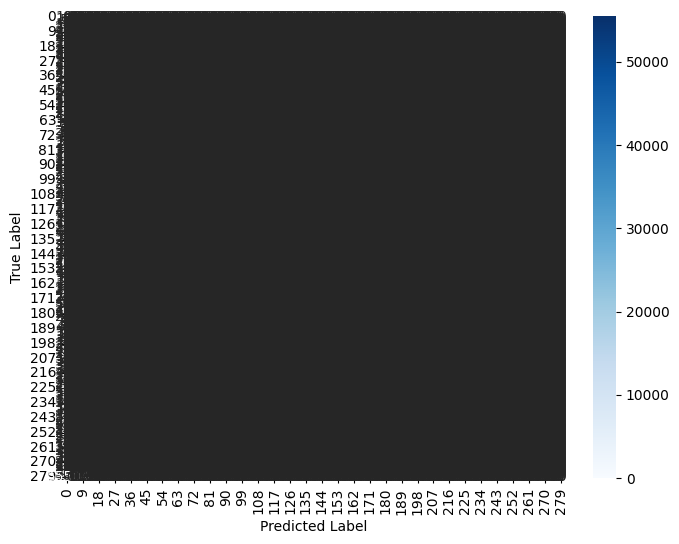

In [ ]:
# Evaluar el modelo
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc}")
print(f"Validation Loss: {val_loss}")

# Generar predicciones y matriz de confusión
y_pred = (model.predict(validation_generator) > 0.5).astype("int32")
y_true = validation_generator.classes

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

# Mostrar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Graficar la precisión y la pérdida

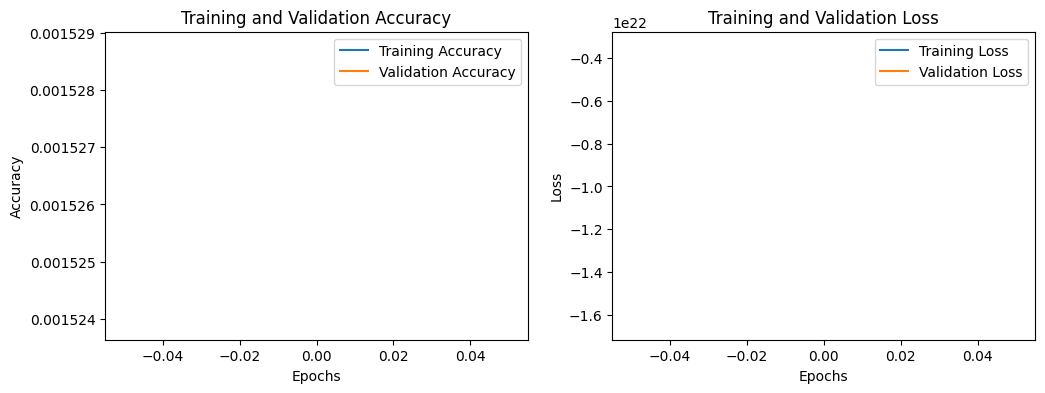

In [ ]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


# Realizar predicciones con nuevas imágenes y evaluar el modelo

In [ ]:
# Cargar algunas imágenes de prueba
test_img_path = "/content/sample_data/mnist_test.csv"

# Mostrar y hacer predicciones
for img_name in os.listdir(test_img_path)[:5]:
    img_path = os.path.join(test_img_path, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Maligno" if prediction > 0.5 else "Benigno"

    plt.imshow(img)
    plt.title(f"Predicción: {label}")
    plt.axis("off")
    plt.show()


NotADirectoryError: [Errno 20] Not a directory: '/content/sample_data/mnist_test.csv'

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Cargar algunas imágenes de prueba
# Assuming you have images in a directory called 'test_images'
# Change this path to your actual image directory
test_img_dir = "/content/sample_data/mnist_train_small.csv" # Updated: Now pointing to a directory

# Mostrar y hacer predicciones
for img_name in os.listdir(test_img_dir)[:5]: # Updated: Using the directory path
    img_path = os.path.join(test_img_dir, img_name) # Updated: Using the directory path
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Maligno" if prediction > 0.5 else "Benigno"

    plt.imshow(img)
    plt.title(f"Predicción: {label}")
    plt.axis("off")
    plt.show()

In [ ]:
import os

test_img_dir = "/content/sample_data/mnist_train_small.csv"

if os.path.exists(test_img_dir):
    print("La ruta existe.")
else:
    print("La ruta no existe. Verifica la ubicación de tus imágenes.")


La ruta existe.


In [ ]:
from google.colab import files

# Cargar imágenes en el directorio
uploaded = files.upload()
for filename in uploaded.keys():
    os.rename(filename, os.path.join(test_img_dir, filename))
